### 머신러닝 모델 적합


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier , StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import cross_val_score,GridSearchCV

In [2]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.1,0.71,0.72,0.73,0.74,0.75]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()


In [3]:
train_df = pd.read_csv('./train_final_over.csv',encoding='UTF-8-sig',index_col=0)
train_df = train_df[['거래량','주간','카드거래간시간','하반기','category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel','중서부','남부','서부','북동부','이상거래','대도시','중소도시','소도시']]
x_train = train_df.drop('이상거래',axis=1)
y_train = train_df[['이상거래']]

In [4]:
test_df = pd.read_csv('./test_final.csv',encoding='UTF-8-sig',index_col=0)
test_df = test_df[['거래량','주간','카드거래간시간','하반기','category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel','중서부','남부','서부','북동부','이상거래','대도시','중소도시','소도시']]
x_test = test_df.drop(['이상거래'],axis=1)
y_test = test_df[['이상거래']]

In [18]:
train_df.columns

Index(['거래량', '주간', '카드거래간시간', '하반기', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       '중서부', '남부', '서부', '북동부', '이상거래'],
      dtype='object')

In [19]:
test_df.columns

Index(['거래량', '주간', '카드거래간시간', '하반기', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       '중서부', '남부', '서부', '북동부', '이상거래'],
      dtype='object')

In [20]:
## 랜덤포레스트에서 최적의 하이퍼 파라미터를 찾아서 
## 적합후 feature_importance 변수 선택
rf = RandomForestClassifier(random_state=1)
param = {
    'max_depth':[4,5,6],      
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' : [1,2]
}


grid_rf = GridSearchCV(rf,param_grid=param,cv=5,refit=True,scoring='accuracy')
grid_rf.fit(x_train,y_train)

scores_df = pd.DataFrame(grid_rf.cv_results_)
print(scores_df.iloc[:,4:])

KeyboardInterrupt: 

In [27]:
### 진짜 적합
start = time.time()

best_rf =RandomForestClassifier(random_state=1,max_depth=5,min_samples_split=2,min_samples_leaf=1)
best_rf.fit(x_train,y_train)  


pred_rf = best_rf.predict(x_test)
pred_prob_rf = best_rf.predict_proba(x_test)[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=0.80).fit(pred_prob_rf) 
custom_rf = binarizer.transform(pred_prob_rf)


end = time.time()
print(f"모델적합 예측 시간: {end-start}")
 ### 서치로 찾은 하이퍼 파라미터 5,1,2

모델적합 예측 시간: 29.073206663131714


In [28]:
# 임계값 조정하여 precision recall trade_off 확인
get_eval_by_threshold(y_test,pred_prob_rf) 

## 임계값 0.35일 떄 f1 score = 0.896

임곗값: 0.7
##############
 [[549965   3609]
 [   727   1418]] ############
 acc_score: 0.9921974954968248
 f1_score: 0.3954266592303402 
 precision: 0.28207678535906106 
 recall: 0.661072261072261
임곗값: 0.71
##############
 [[550049   3525]
 [   749   1396]] ############
 acc_score: 0.9923090626737614
 f1_score: 0.39513161619020665 
 precision: 0.28368217841902055 
 recall: 0.6508158508158508
임곗값: 0.72
##############
 [[550076   3498]
 [   753   1392]] ############
 acc_score: 0.9923504504974636
 f1_score: 0.39573560767590615 
 precision: 0.2846625766871166 
 recall: 0.6489510489510489
임곗값: 0.73
##############
 [[550107   3467]
 [   754   1391]] ############
 acc_score: 0.9924044346153361
 f1_score: 0.39725831786377264 
 precision: 0.28633182379580074 
 recall: 0.6484848484848484
임곗값: 0.74
##############
 [[550181   3393]
 [   755   1390]] ############
 acc_score: 0.992535795968826
 f1_score: 0.40127020785219397 
 precision: 0.2906125862429438 
 recall: 0.6480186480186481
임곗값: 0.75
######

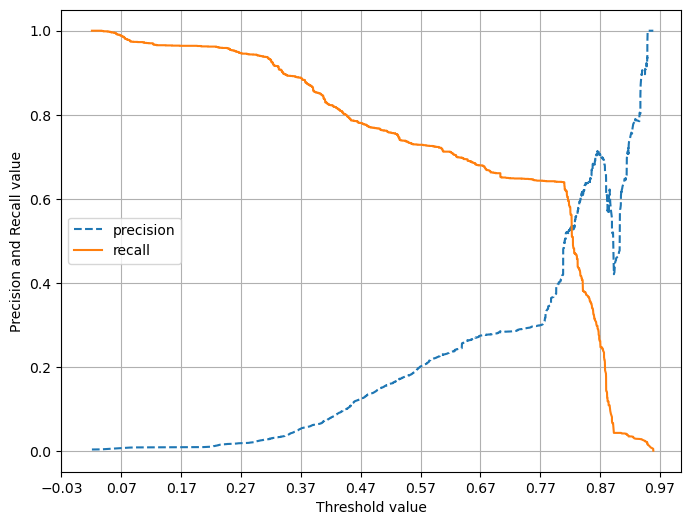

In [25]:
precision_recall_curve_plot(y_test,pred_prob_rf)

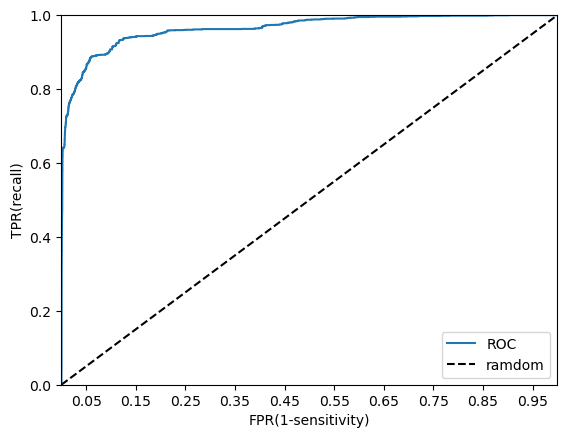

auc 값: 0.9647


In [29]:

## roc 커브 auc 값
roc_curve_plot(y_test,pred_prob_rf)
auc_score = roc_auc_score(y_test,pred_prob_rf)
print(f'auc 값: {np.round(auc_score,4)}')

- logistic

In [ ]:
## 주요 파라미터는 penality, C, solver
# C는 규제 강도를 조절하는 alpha 값의 역수, 즉 C = 1/alpha. C 값이 작을수록 규제 강도가 크다
# 비용함수에 alpha 값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제라고 한다
# 회귀계수가 크면 과적합 발생함
# solver는 회귀 계수 최적화를 위한 다양한 최적화 방식. liblinear 은 solver의 기본 설정값. 다차원이고 작은 데이터 세트에서 효과적으로 동작

lr=LogisticRegression(random_state=1,solver='liblinear')
param = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(lr,param_grid=param,cv=5,refit=True,scoring='accuracy')
grid_lr.fit(x_train,y_train)

scores_df = pd.DataFrame(grid_lr.cv_results_)
print(scores_df.iloc[:,4:])

   param_C param_penalty                         params  split0_test_score  \
0    0.001            l1  {'C': 0.001, 'penalty': 'l1'}           0.885213   
1    0.001            l2  {'C': 0.001, 'penalty': 'l2'}           0.881217   
2     0.01            l1   {'C': 0.01, 'penalty': 'l1'}           0.880995   
3     0.01            l2   {'C': 0.01, 'penalty': 'l2'}           0.876332   
4      0.1            l1    {'C': 0.1, 'penalty': 'l1'}           0.876110   
5      0.1            l2    {'C': 0.1, 'penalty': 'l2'}           0.875222   
6        1            l1      {'C': 1, 'penalty': 'l1'}           0.873002   
7        1            l2      {'C': 1, 'penalty': 'l2'}           0.873224   
8       10            l1     {'C': 10, 'penalty': 'l1'}           0.872780   
9       10            l2     {'C': 10, 'penalty': 'l2'}           0.872780   
10     100            l1    {'C': 100, 'penalty': 'l1'}           0.872780   
11     100            l2    {'C': 100, 'penalty': 'l2'}         

In [33]:
start = time.time()

best_lr=LogisticRegression(random_state=1,solver='liblinear',penalty='l1',C=0.01)

best_lr.fit(x_train,y_train)

pred_lr = best_lr.predict(x_test)
pred_prob_lr = best_lr.predict_proba(x_test)[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=0.65).fit(pred_prob_lr) 
custom_lr = binarizer.transform(pred_prob_lr)

end = time.time()
print(f"모델적합 예측 시간: {end-start}")

모델적합 예측 시간: 1.9543921947479248


In [34]:
pd.Series(best_lr.coef_[0],index=x_train.columns).sort_values() 
## 라쏘 규제를 통하여 변수의 영향을 0으로 만든 변수들이 존재
## 카테고리 변수중에도 gas_transport 와 grocery_pos의 경우 이상거래일 확률이 올라감

category_shopping_pos     -6.965235
category_shopping_net     -6.624615
category_misc_net         -6.080041
category_entertainment    -5.429638
category_misc_pos         -5.291224
category_travel           -5.206722
category_home             -5.015575
category_grocery_net      -4.875996
category_health_fitness   -4.809700
category_kids_pets        -4.363620
category_food_dining      -4.317680
category_personal_care    -4.175703
category_grocery_pos      -3.680327
category_gas_transport    -3.500767
주간                        -2.766049
하반기                       -1.205715
카드거래간시간                   -0.466066
실소유자나이                     0.036897
거래량                        3.427766
dtype: float64

In [35]:
# 임계값 조정하여 precision recall trade_off 확인
get_eval_by_threshold(y_test,pred_prob_lr) 

## 임계값 0.35일 떄 f1 score = 0.896

임곗값: 0.7
##############
 [[550393   3181]
 [   781   1364]] ############
 acc_score: 0.9928704974996356
 f1_score: 0.4077727952167414 
 precision: 0.30011001100110013 
 recall: 0.6358974358974359
임곗값: 0.71
##############
 [[550478   3096]
 [   796   1349]] ############
 acc_score: 0.9929964604413382
 f1_score: 0.4094081942336874 
 precision: 0.3034870641169854 
 recall: 0.6289044289044289
임곗값: 0.72
##############
 [[550549   3025]
 [   806   1339]] ############
 acc_score: 0.9931062281476789
 f1_score: 0.41143032723920725 
 precision: 0.30682859761686526 
 recall: 0.6242424242424243
임곗값: 0.73
##############
 [[550626   2948]
 [   825   1320]] ############
 acc_score: 0.9932105974422325
 f1_score: 0.411663807890223 
 precision: 0.30927835051546393 
 recall: 0.6153846153846154
임곗값: 0.74
##############
 [[550707   2867]
 [   845   1300]] ############
 acc_score: 0.9933203651485732
 f1_score: 0.41191381495564006 
 precision: 0.3119750419966403 
 recall: 0.6060606060606061
임곗값: 0.75
#######

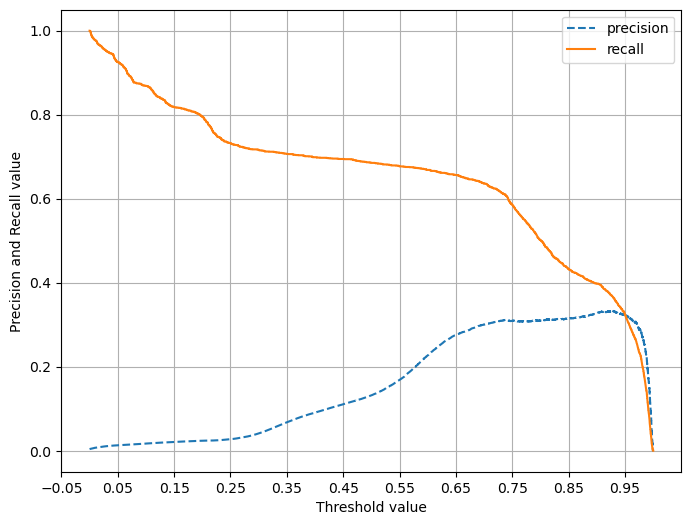

In [37]:
precision_recall_curve_plot(y_test,pred_prob_lr)

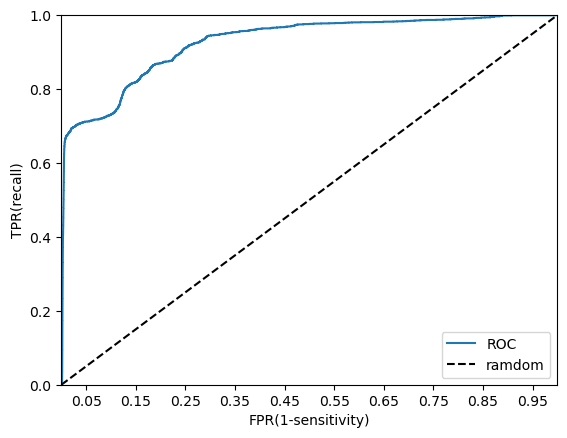

auc 값: 0.9269


In [38]:
## roc 커브 auc 값
roc_curve_plot(y_test,pred_prob_lr)
auc_score = roc_auc_score(y_test,pred_prob_lr)
print(f'auc 값: {np.round(auc_score,4)}')

- svm

In [ ]:
start = time.time()
svm = SVC(random_state=1)
param = {
    'gamma':['scale','auto'],
    'C':[10,1,0.1,0.01],
    'kernel':['rbf']
}

grid_svm = GridSearchCV(svm,param_grid=param,cv=5,refit=True,scoring='accuracy')
grid_svm.fit(x_train,y_train)

scores_df = pd.DataFrame(grid_svm.cv_results_)
print(scores_df.iloc[:,4:])



In [5]:
start = time.time()

best_svm = SVC(random_state=1, C=1, gamma='auto', kernel='rbf', probability=True)

best_svm.fit(x_train,y_train)

pred_svm = best_svm.predict(x_test)
pred_prob_svm = best_svm.predict_proba(x_test)[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=0.96).fit(pred_prob_svm) 
custom_svc = binarizer.transform(pred_prob_svm)

end = time.time()
print(f"모델적합 예측 시간: {end-start}")

모델적합 예측 시간: 4315.240286111832


In [6]:
# 임계값 조정하여 precision recall trade_off 확인
get_eval_by_threshold(y_test,pred_prob_svm,thresholds=[0.96]) 

## 임계값 0.35일 떄 f1 score = 0.90517

임곗값: 0.96
##############
 [[552856    718]
 [  1002   1143]] ############
 acc_score: 0.9969049105753087
 f1_score: 0.5706440339490764 
 precision: 0.614185921547555 
 recall: 0.5328671328671328


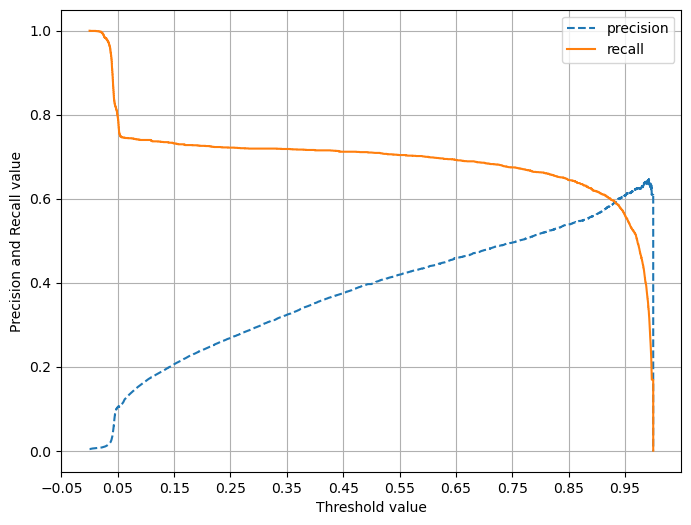

In [7]:
precision_recall_curve_plot(y_test,pred_prob_svm)

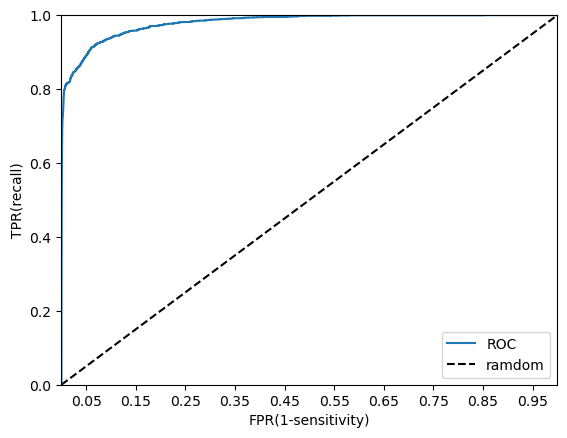

auc 값: 0.9798


In [10]:
## roc 커브 auc 값
roc_curve_plot(y_test,pred_prob_svm)
auc_score = roc_auc_score(y_test,pred_prob_svm)
print(f'auc 값: {np.round(auc_score,4)}')

- knn

In [ ]:
start = time.time()
knn = KNeighborsClassifier(n_jobs=-1)
param={
    'n_neighbors':[3,4,5,6,7,8,9,10]
}

grid_knn = GridSearchCV(knn,param_grid=param,cv=5,refit=True,scoring='accuracy')
grid_knn.fit(x_train,y_train)

scores_df = pd.DataFrame(grid_knn.cv_results_)
print(scores_df.iloc[:,4:])
end = time.time()
print(f"모델적합 예측 시간: {end-start}")

  param_n_neighbors               params  split0_test_score  \
0                 3   {'n_neighbors': 3}           0.933393   
1                 4   {'n_neighbors': 4}           0.933615   
2                 5   {'n_neighbors': 5}           0.930284   
3                 6   {'n_neighbors': 6}           0.932726   
4                 7   {'n_neighbors': 7}           0.931172   
5                 8   {'n_neighbors': 8}           0.934281   
6                 9   {'n_neighbors': 9}           0.930284   
7                10  {'n_neighbors': 10}           0.929174   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.939387           0.924734           0.942483           0.936931   
1           0.941829           0.926066           0.943593           0.939596   
2           0.941607           0.925844           0.942483           0.935821   
3           0.942940           0.925622           0.940928           0.938041   
4           0.943384       

In [94]:
best_knn = KNeighborsClassifier() ## 디폴트로 넣는 것이 좋아보임

best_knn.fit(x_train,y_train)

pred_knn = best_knn.predict(x_test)
pred_prob_knn = best_knn.predict_proba(x_test)[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=0.35).fit(pred_prob_lr) 
custom_knn = binarizer.transform(pred_prob_knn)

In [95]:
get_eval_by_threshold(y_test,pred_prob_knn )

임곗값: 0.25
##############
 [[4021  269]
 [ 163 1982]] ############
 acc_score: 0.9328671328671329
 f1_score: 0.9017288444040037 
 precision: 0.8804975566414927 
 recall: 0.924009324009324
임곗값: 0.3
##############
 [[4021  269]
 [ 163 1982]] ############
 acc_score: 0.9328671328671329
 f1_score: 0.9017288444040037 
 precision: 0.8804975566414927 
 recall: 0.924009324009324
임곗값: 0.35
##############
 [[4021  269]
 [ 163 1982]] ############
 acc_score: 0.9328671328671329
 f1_score: 0.9017288444040037 
 precision: 0.8804975566414927 
 recall: 0.924009324009324
임곗값: 0.45
##############
 [[4154  136]
 [ 280 1865]] ############
 acc_score: 0.9353535353535354
 f1_score: 0.8996623251326581 
 precision: 0.9320339830084957 
 recall: 0.8694638694638694
임곗값: 0.5
##############
 [[4154  136]
 [ 280 1865]] ############
 acc_score: 0.9353535353535354
 f1_score: 0.8996623251326581 
 precision: 0.9320339830084957 
 recall: 0.8694638694638694


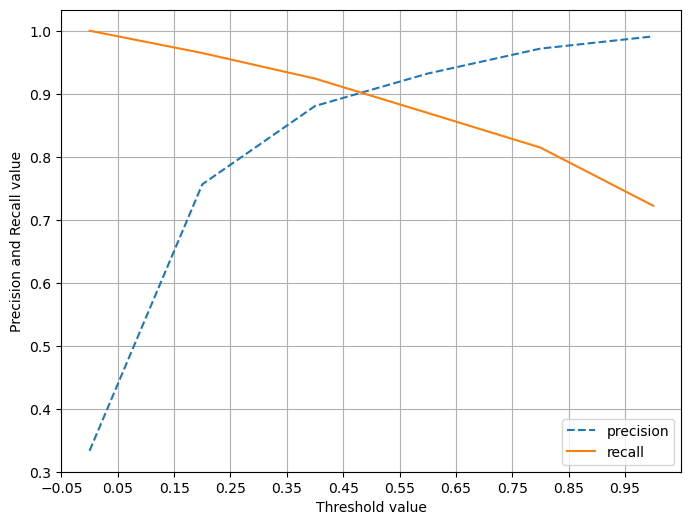

In [96]:
precision_recall_curve_plot(y_test,pred_prob_knn)

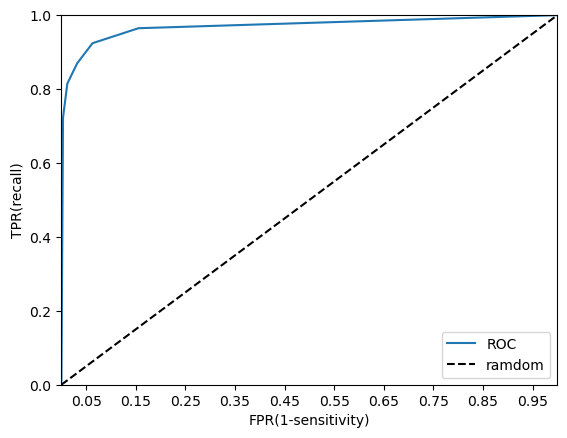

auc 값: 0.9695


In [97]:
## roc 커브 auc 값
roc_curve_plot(y_test,pred_prob_knn)
auc_score = roc_auc_score(y_test,pred_prob_knn)
print(f'auc 값: {np.round(auc_score,4)}')

### XGBoost

In [53]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.fit(x_train,y_train)
pred_xgb = xgb.predict(x_test)
pred_proba_xgb = xgb.predict_proba(x_test)[:,1].reshape(-1,1)

In [60]:
get_eval_by_threshold(y_test,pred_proba_xgb,thresholds=[0.94])

임곗값: 0.94
##############
 [[553078    496]
 [   632   1513]] ############
 acc_score: 0.9979701971679932
 f1_score: 0.7284545016851227 
 precision: 0.75311100049776 
 recall: 0.7053613053613054


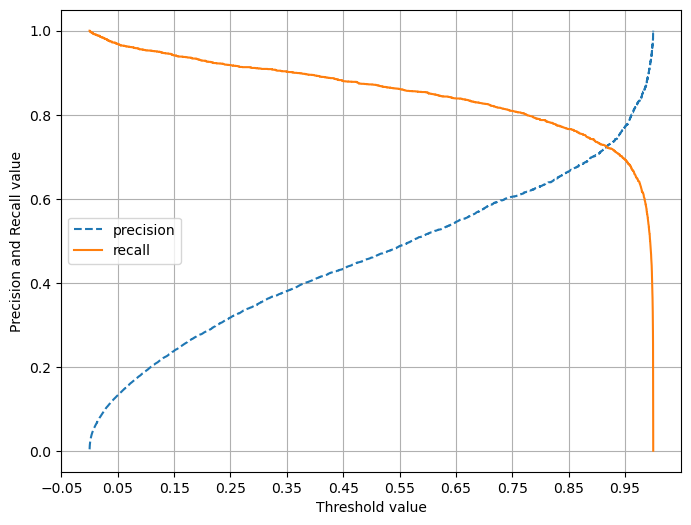

In [55]:
precision_recall_curve_plot(y_test,pred_proba_xgb)

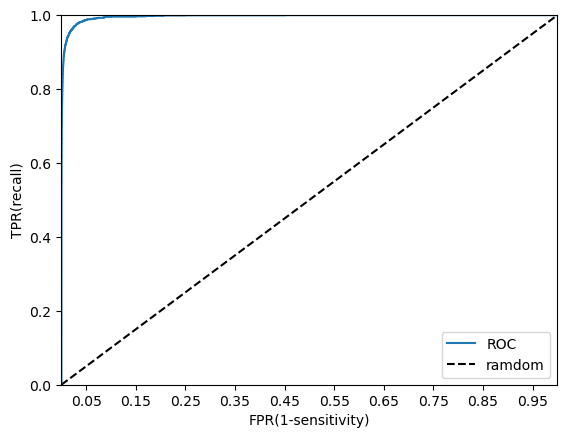

auc 0.9963915517644558


In [50]:
roc_curve_plot(y_test,pred_proba_xgb)
print(f'auc {roc_auc_score(y_test,pred_proba_xgb)}')

In [29]:
pd.Series(xgb.feature_importances_,index=x_train.columns).sort_values(ascending=False)

주간                         0.148999
중서부                        0.097595
거래량                        0.086095
남부                         0.061367
category_shopping_net      0.058889
category_grocery_pos       0.058316
서부                         0.057312
category_misc_net          0.045038
category_shopping_pos      0.044817
category_home              0.043576
category_gas_transport     0.039436
북동부                        0.035757
category_entertainment     0.034598
하반기                        0.030620
category_misc_pos          0.025348
category_health_fitness    0.023203
category_travel            0.022445
category_food_dining       0.021267
category_grocery_net       0.021117
category_kids_pets         0.020429
category_personal_care     0.019774
카드거래간시간                    0.004003
dtype: float32